In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']=str(1)

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from models import seq2point

In [4]:
from jax.flatten_util import ravel_pytree
import blackjax
from probml_utils.blackjax_utils import inference_loop

In [5]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

In [6]:
train ={1:{
              'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }}
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }}
appliances = ["Refrigerator"]

In [7]:
datas = dataset_load(appliances, train, test, 99,split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test,y_test = datas[4],datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [8]:
y_cal[:,0]

DeviceArray([ 1.5623691 , -0.66970474, -0.6681717 , ..., -0.7402235 ,
              1.4964492 , -0.6689382 ], dtype=float32)

In [9]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[:,0]
calibration_predictions_df['Ground Truth']=scaler_y.inverse_transform(y_cal)[:,0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test


## Seq2point

In [10]:
model = seq2point.seq2point()


In [11]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=32, learning_rate=0.001, epochs=50)

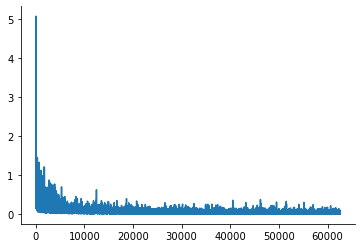

In [12]:
plt.plot(losses)
sns.despine()

In [13]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 1min 22s'

#### Training Results

In [14]:
y_hat = model.apply(params, x_train, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [15]:
y_hat = scaler_y.inverse_transform(y_hat)
y_true = scaler_y.inverse_transform(y_train)

In [16]:
print(f"RMSE : {errors.rmse(y_true, y_hat):.4f} MAE  : {errors.mae(y_true, y_hat):.4f}")

RMSE : 8.5919 MAE  : 4.8055


In [17]:
training_predictions_df['mean']=y_hat[:,0]

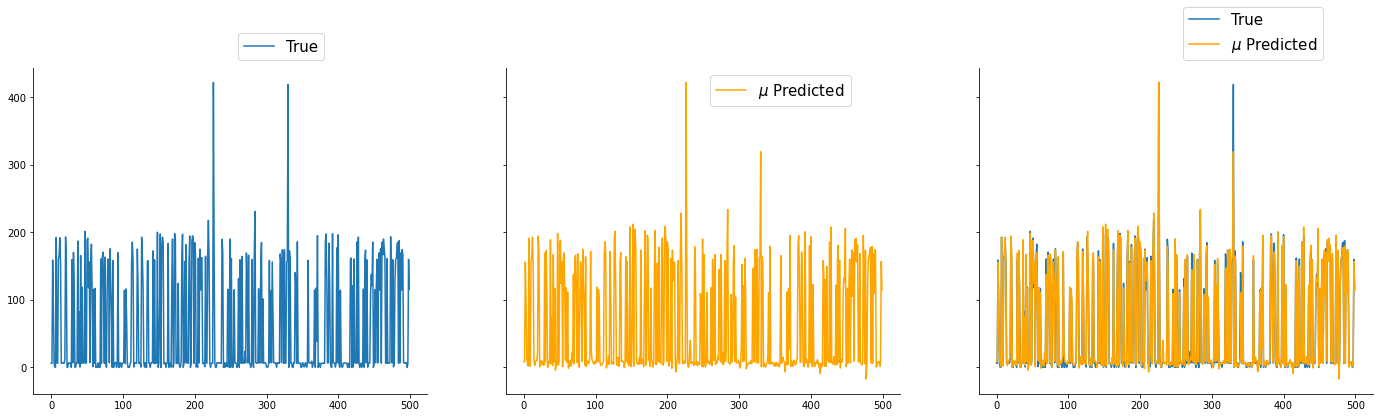

In [18]:
idx1 = 0
idx2 = 500
fig, ax = plt.subplots(1, 3, figsize=(24,6),sharey='row')
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(y_hat[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(y_hat[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Calibration Set Results

In [19]:
y_hat_cal = model.apply(params, x_cal, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [20]:
y_hat_cal = scaler_y.inverse_transform(y_hat_cal)
y_true_cal = scaler_y.inverse_transform(y_cal)

In [21]:
print(f"RMSE : {errors.rmse(y_true_cal, y_hat_cal):.4f} MAE  : {errors.mae(y_true_cal, y_hat_cal):.4f}")

RMSE : 16.3745 MAE  : 7.7071


In [22]:
calibration_predictions_df['mean']=y_hat_cal[:,0]

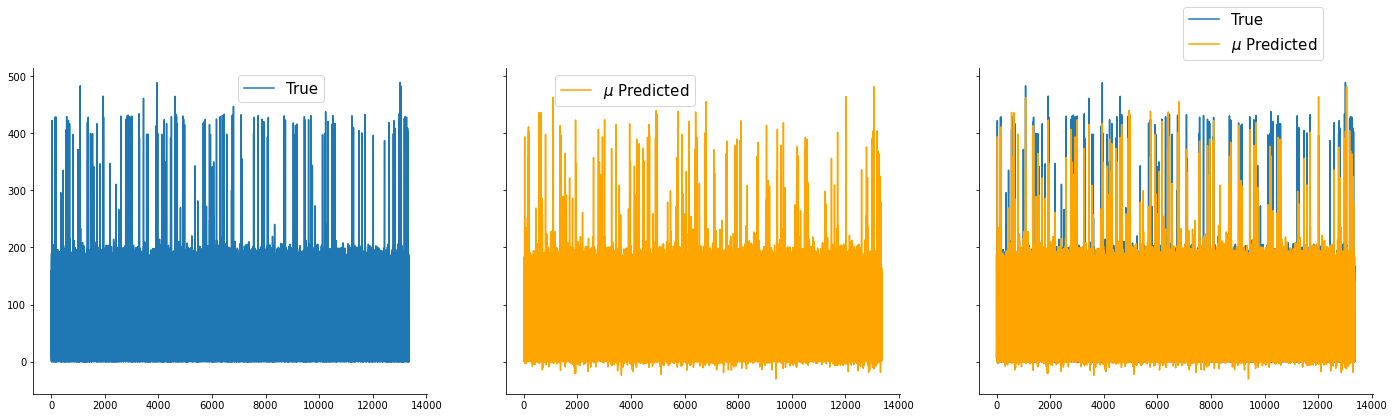

In [23]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(1, 3, figsize=(24,6),sharey='row')
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(y_hat_cal[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(y_hat_cal[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Testing Results

In [24]:
%%capture cap
%%time
y_hat = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})
y_hat = scaler_y.inverse_transform(y_hat)

In [25]:
mlp_testing_time = cap.stdout.split('\n')[1]

In [26]:
testing_predictions_df["mean"] = y_hat

In [27]:
print(f"RMSE : {errors.rmse(y_test, y_hat):.4f}\nMAE  : {errors.mae(y_test,y_hat):.4f}")

RMSE : 43.1432
MAE  : 26.1645


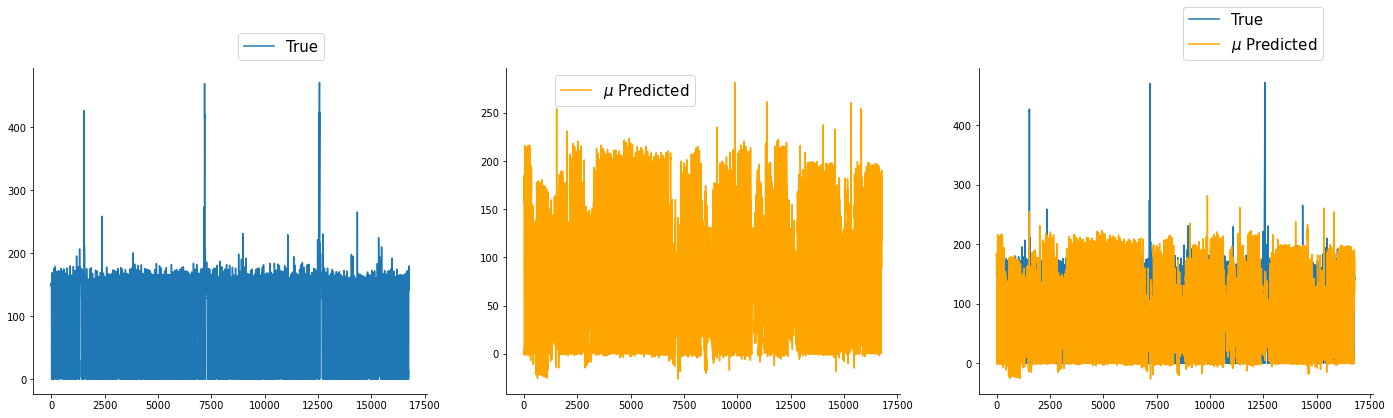

In [28]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(1, 3, figsize=(24,6))
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(y_hat[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(y_hat[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

## MC Dropout

In [29]:
n_stacks = 10
fn = lambda x, i : model.apply(params, x, False, rngs={"dropout": jax.random.PRNGKey(i)})

#### Training Results

In [30]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_train, jnp.arange(n_stacks))

2022-07-23 13:28:27.515772: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[400920,99,50]{1,2,0}, u8[0]{0}) custom-call(f32[400920,99,50]{1,2,0}, f32[5,50,50]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


In [31]:
mc_train_mean =  y_stacks.mean(axis=0)
mc_train_sigma = y_stacks.std(axis=0)

In [32]:
mc_train_mean = scaler_y.inverse_transform(mc_train_mean)
mc_train_sigma = (scaler_y.scale_*mc_train_sigma)

In [33]:
print(f"RMSE : {errors.rmse(y_true, mc_train_mean):.4f}", f"MAE  : {errors.mae(y_true, mc_train_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_train_mean, mc_train_sigma, y_true):.4f}")

RMSE : 9.0468 MAE  : 5.1669 NLL  : 3.1540


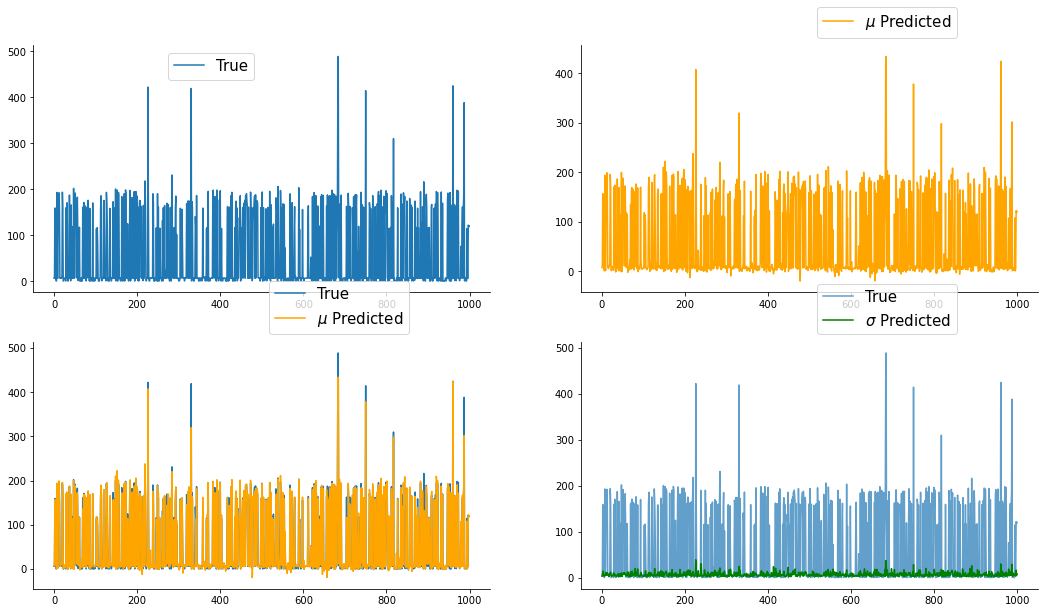

In [34]:
idx1 = 0
idx2 = 1000
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [35]:
training_predictions_df['MC_mean']=mc_train_mean
training_predictions_df['MC_sigma']=mc_train_sigma

In [36]:
training_predictions_df.head()

,Ground Truth,mean,MC_mean,MC_sigma
0,6.375000,8.175156,7.514252,3.065719
1,6.062500,8.984951,10.883694,2.714251
2,159.062500,156.071884,156.782288,5.689392
3,89.333336,98.139542,99.518295,14.057793
4,6.062500,14.230667,10.723888,4.540873


#### Calibration Set Results

In [37]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_cal, jnp.arange(n_stacks))

2022-07-23 13:28:33.467579: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[133640,99,50]{1,2,0}, u8[0]{0}) custom-call(f32[133640,99,50]{1,2,0}, f32[5,50,50]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


In [38]:
mc_cal_mean =  y_stacks.mean(axis=0)
mc_cal_sigma = y_stacks.std(axis=0)

In [39]:
mc_cal_mean = scaler_y.inverse_transform(mc_cal_mean)
mc_cal_sigma = (scaler_y.scale_*mc_cal_sigma)

In [40]:
print(f"RMSE : {errors.rmse(y_true_cal, mc_cal_mean):.4f}", f"MAE  : {errors.mae(y_true_cal, mc_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_cal_mean, mc_cal_sigma, y_true_cal):.4f}")

RMSE : 16.7859 MAE  : 8.1224 NLL  : 3.9250


In [41]:
calibration_predictions_df['MC_Mean'] =mc_cal_mean
calibration_predictions_df['MC_Sigma'] =mc_cal_sigma

#### Testing Results

In [42]:
%%capture cap
%%time
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_test, jnp.arange(n_stacks))

2022-07-23 13:28:37.492089: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[167810,99,50]{1,2,0}, u8[0]{0}) custom-call(f32[167810,99,50]{1,2,0}, f32[5,50,50]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


In [43]:
mc_testing_time = cap.stdout.split('\n')[1]
mc_testing_time

'Wall time: 2.38 s'

In [44]:
mc_test_mean =  y_stacks.mean(axis=0)
mc_test_sigma = y_stacks.std(axis=0)

In [45]:
mc_test_mean = scaler_y.inverse_transform(mc_test_mean)
mc_test_sigma = (scaler_y.scale_*mc_test_sigma)

In [46]:
print(f"RMSE : {errors.rmse(y_test, mc_test_mean):.4f}", f"MAE  : {errors.mae(y_test, mc_test_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_test_mean, mc_test_sigma, y_test):.4f}")

RMSE : 43.0711 MAE  : 26.2272 NLL  : 13.6892


In [47]:
testing_predictions_df['MC_Mean'] =  mc_test_mean
testing_predictions_df['MC_Sigma'] = mc_test_sigma

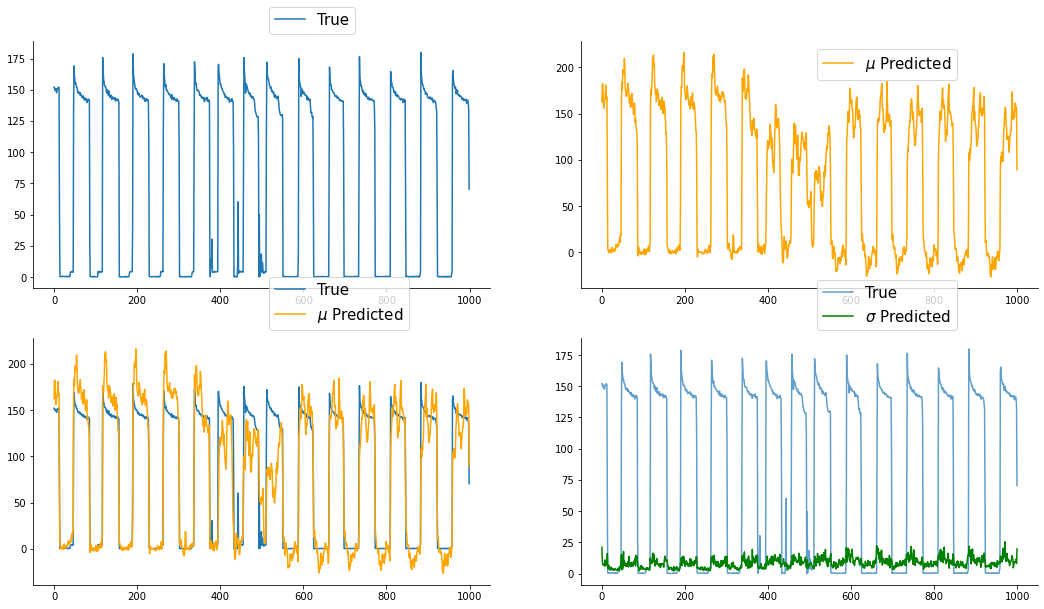

In [48]:
idx1 = 0
idx2 = 1000
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

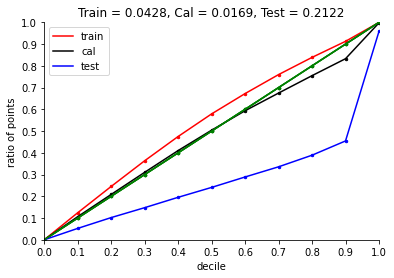

In [49]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(mc_train_mean.squeeze(), mc_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(mc_cal_mean.squeeze(), mc_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(mc_test_mean.squeeze(), mc_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Deep Ensemble

In [50]:
def de_train(x, y, i, model):
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, x, y, False, batch_size=32, 
                      learning_rate=0.001, epochs=50)
    return param, losses
    
de_train = jax.tree_util.Partial(de_train, model=model)

def predict(x, param, model):
    yhat = model.apply(param,x,True)
    return yhat
test_ = jax.tree_util.Partial(predict, model=model)

In [51]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(de_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

2022-07-23 13:28:42.644053: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[32,99,400]{1,2,0}, u8[0]{0}) custom-call(f32[32,104,300]{1,2,0}, f32[6,30,400]{0,1,2}), window={size=6}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-07-23 13:28:42.672753: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[8,30,300]{0,2,1}, u8[0]{0}) custom-call(f32[320,106,30]{1,0,2}, f32[32,99,300]{1,0,2}), window={size=99}, dim_labels=f0b_i0o->0bf, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",

In [52]:
de_training_time = cap.stdout.split('\n')[1]
de_training_time

'Wall time: 7min 16s'

#### Training Results

In [53]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
de_train_mean = y_stacks.mean(axis=0)
de_train_sigma= y_stacks.std(axis=0)

2022-07-23 13:35:59.098584: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[40092,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[40092,99,400]{1,2,0}, f32[5,40,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-07-23 13:36:02.257488: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[40092,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[40092,99,500]{1,2,0}, f32[5,50,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\

In [54]:
de_train_mean = scaler_y.inverse_transform(de_train_mean)
de_train_sigma = (scaler_y.scale_*de_train_sigma)


In [55]:
print(f"RMSE : {errors.rmse(y_true, de_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, de_train_mean):.4f}", 
      f"NLL  : {errors.NLL(de_train_mean, de_train_sigma, y_true):.4f}")

RMSE : 5.3635 MAE  : 2.8740 NLL  : 2.6537


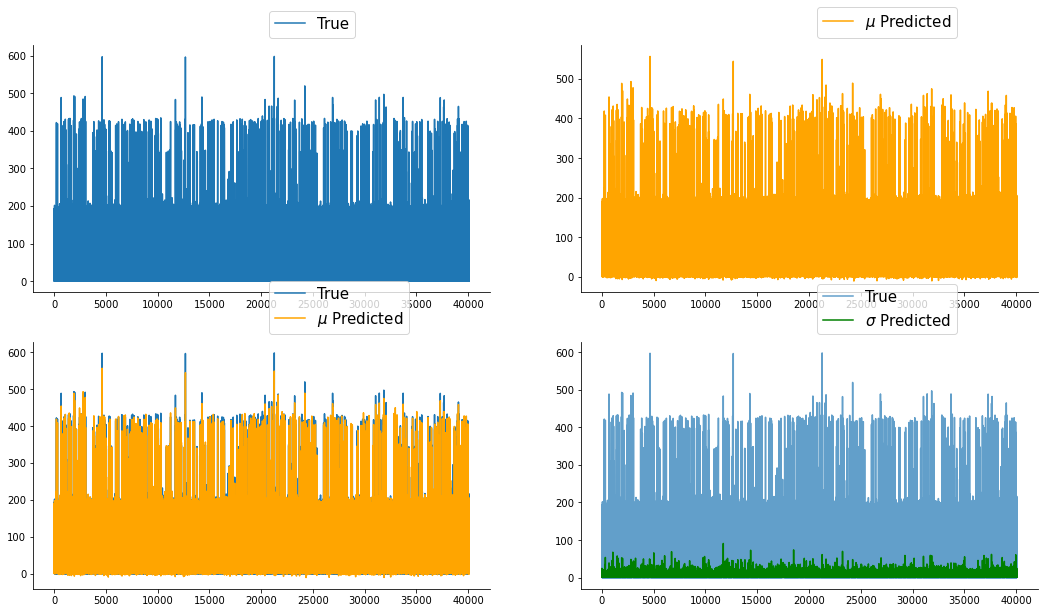

In [56]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [57]:
training_predictions_df['DE_mean']=de_train_mean
training_predictions_df['DE_sigma']=de_train_sigma

#### Calibration Set Results

In [58]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_cal, params_list)
de_cal_mean = y_stacks.mean(axis=0)
de_cal_sigma= y_stacks.std(axis=0)

2022-07-23 13:36:10.540338: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[13364,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[13364,99,500]{1,2,0}, f32[5,50,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


In [59]:
de_cal_mean = scaler_y.inverse_transform(de_cal_mean)
de_cal_sigma = (scaler_y.scale_*de_cal_sigma)



In [60]:
print(f"RMSE : {errors.rmse(y_true_cal, de_cal_mean):.4f}", 
      f"MAE  : {errors.mae(y_true_cal, de_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(de_cal_mean, de_cal_sigma, y_true_cal):.4f}")

RMSE : 15.0225 MAE  : 6.3635 NLL  : 3.1601


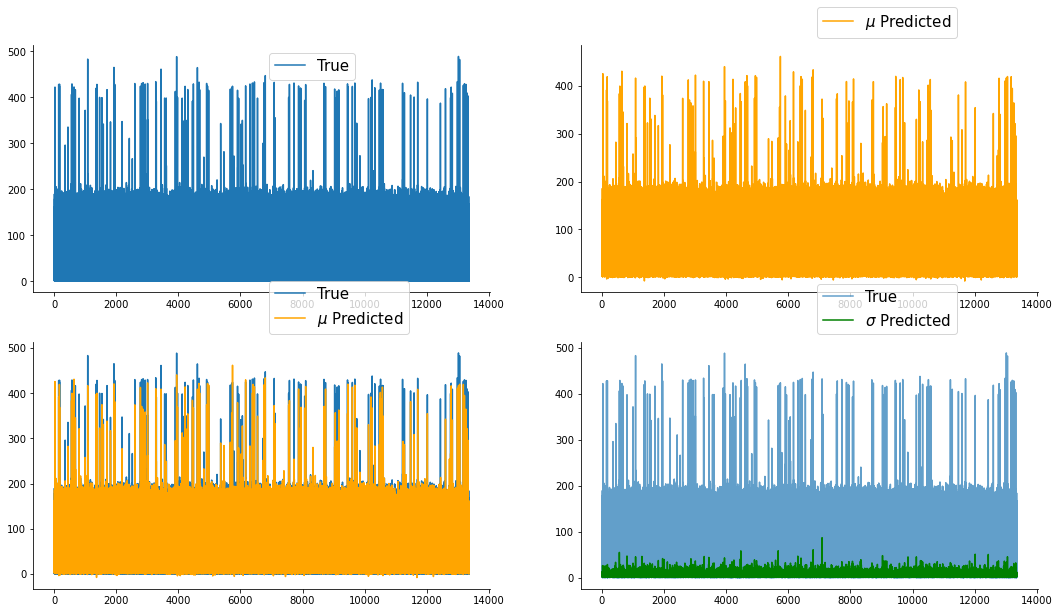

In [61]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(de_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(de_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [62]:
calibration_predictions_df['DE_mean']=de_cal_mean
calibration_predictions_df['DE_sigma']=de_cal_sigma

In [63]:
calibration_predictions_df.head()

,Ground Truth,mean,MC_Mean,MC_Sigma,DE_mean,DE_sigma
0,188.062515,182.687347,183.784149,6.916214,184.438065,3.620708
1,6.062500,9.711658,10.801510,4.300830,9.043953,3.855364
2,6.187500,6.437878,4.295872,3.235567,7.045453,1.544293
3,160.437500,151.589676,149.142029,6.577250,159.310211,7.122504
4,118.687500,116.602501,111.568893,8.372508,123.223602,10.416428


#### Testing Results

In [64]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_test, params_list)

2022-07-23 13:36:15.167857: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[16781,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[16781,99,400]{1,2,0}, f32[5,40,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-07-23 13:36:16.576777: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[16781,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[16781,99,500]{1,2,0}, f32[5,50,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\

In [65]:
de_testing_time = cap.stdout.split('\n')[1]
de_testing_time

'Wall time: 4.5 s'

In [66]:
de_test_mean = y_stacks.mean(axis=0)
de_test_sigma= y_stacks.std(axis=0)

In [67]:
de_test_mean = scaler_y.inverse_transform(de_test_mean)
de_test_sigma = (scaler_y.scale_*de_test_sigma)

In [68]:
testing_predictions_df['de_Mean'] =  de_test_mean
testing_predictions_df['de_Sigma'] = de_test_sigma

In [69]:
print(f"RMSE : {errors.rmse(y_test, de_test_mean):.4f}", f"MAE  : {errors.mae(y_test, de_test_mean):.4f}", 
      f"NLL  : {errors.NLL(de_test_mean, de_test_sigma, y_test):.4f}")

RMSE : 41.8752 MAE  : 24.7377 NLL  : 7.3487


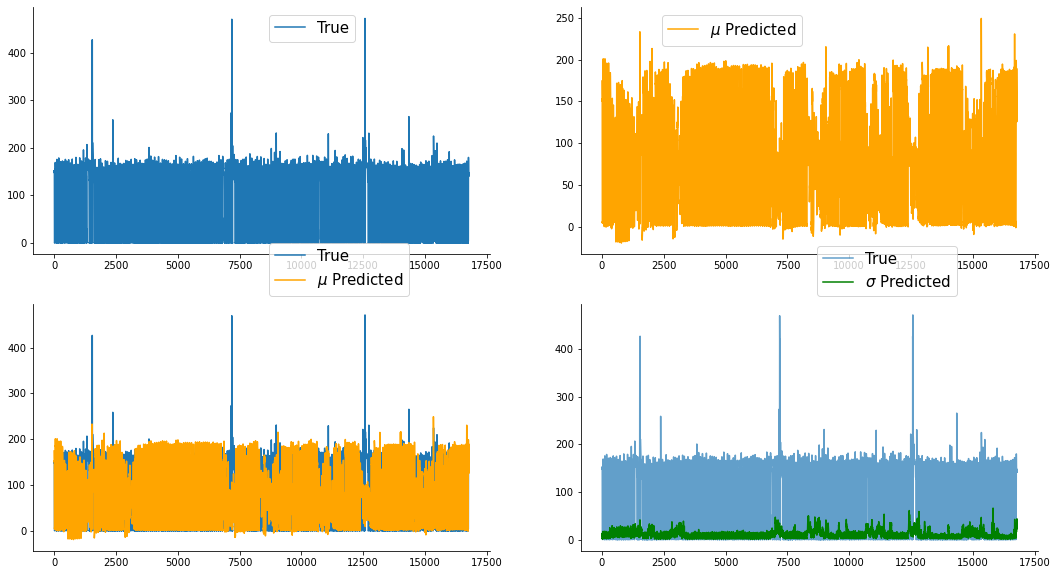

In [70]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

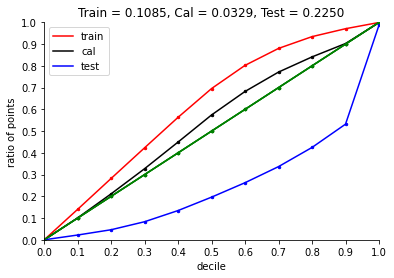

In [71]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(de_train_mean.squeeze(), de_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(de_cal_mean.squeeze(), de_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(de_test_mean.squeeze(), de_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Bootstrap

In [72]:
def bs_train(x, y, i, model):
    idx = jax.random.choice(jax.random.PRNGKey(i), jnp.arange(len(x)), (len(x),))
    new_x, new_y = x[idx], y[idx]
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, new_x, new_y, True, batch_size=32, 
                      learning_rate=0.001, epochs= 50)
    return param, losses

bs_train = jax.tree_util.Partial(bs_train, model=model)

In [73]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(bs_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [74]:
bs_training_time = cap.stdout.split('\n')[1]
bs_training_time

'Wall time: 8min 17s'

#### Training Results

In [75]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
bs_train_mean = y_stacks.mean(axis=0)
bs_train_sigma= y_stacks.std(axis=0)

In [76]:
bs_train_mean = scaler_y.inverse_transform(bs_train_mean)
bs_train_sigma = scaler_y.scale_*bs_train_sigma

In [77]:
y_train.shape

(40092, 1)

In [78]:
print(f"RMSE : {errors.rmse(y_true, bs_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, bs_train_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_train_mean, bs_train_sigma, y_true):.4f}")

RMSE : 8.4302 MAE  : 3.7934 NLL  : 2.4106


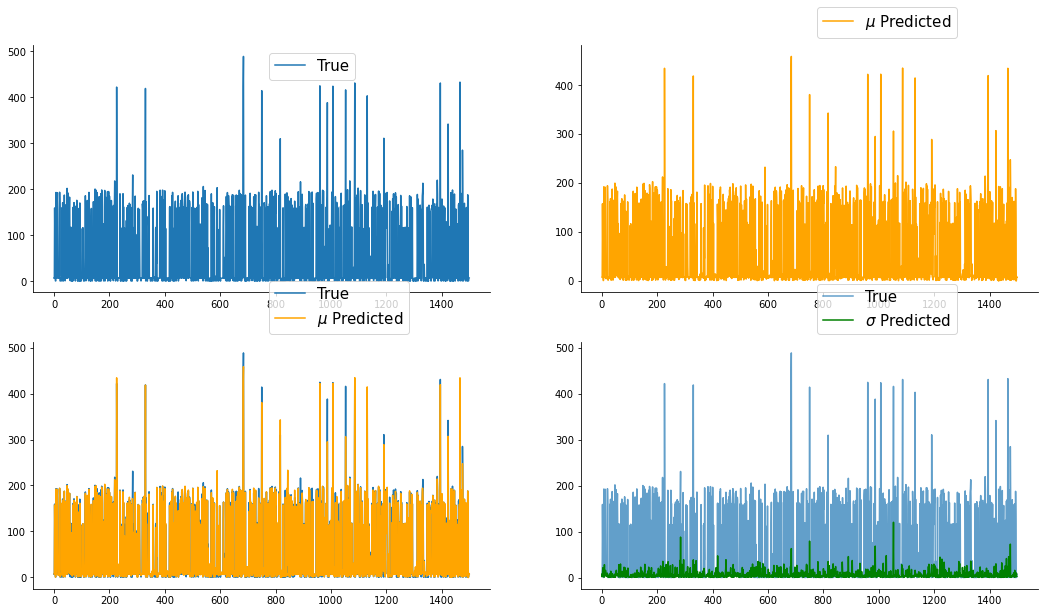

In [79]:
idx1 = 0
idx2 = 1500
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [80]:
training_predictions_df['BS_mean']=bs_train_mean
training_predictions_df['BS_sigma']=bs_train_sigma

#### Calibration Set Results

In [81]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_cal, params_list)
bs_cal_mean = y_stacks.mean(axis=0)
bs_cal_sigma= y_stacks.std(axis=0)

In [82]:
bs_cal_mean = scaler_y.inverse_transform(bs_cal_mean)
bs_cal_sigma = scaler_y.scale_*bs_cal_sigma

In [83]:
print(f"RMSE : {errors.rmse(y_true_cal, bs_cal_mean):.4f}", 
      f"MAE  : {errors.mae(y_true_cal, bs_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_cal_mean, bs_cal_sigma, y_true_cal):.4f}")

RMSE : 18.9423 MAE  : 8.5071 NLL  : 3.0120


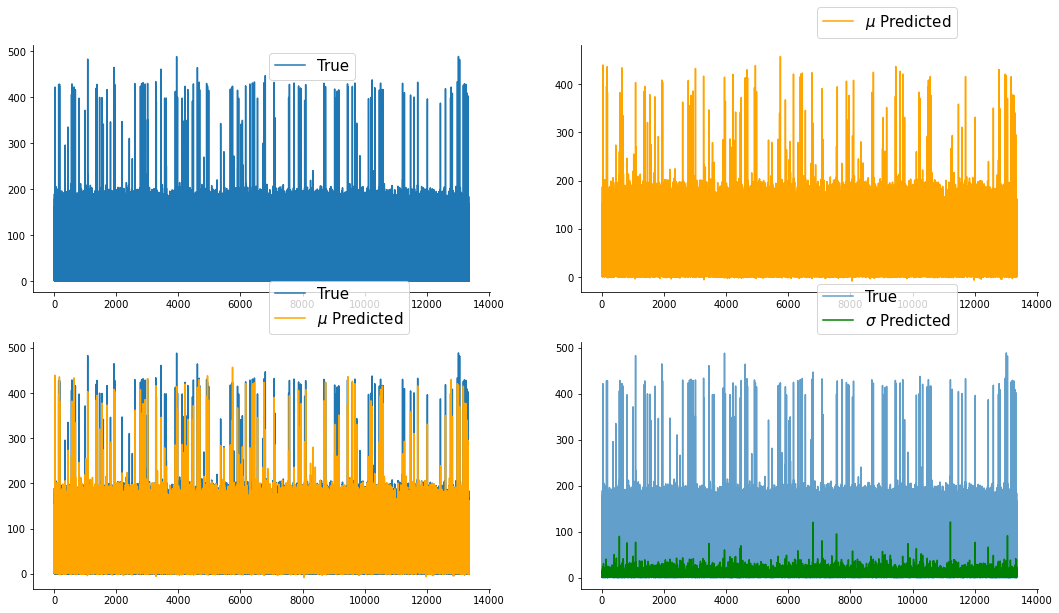

In [84]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(bs_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(bs_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [85]:
calibration_predictions_df['bs_Mean'] =  bs_cal_mean
calibration_predictions_df['bs_Sigma'] = bs_cal_sigma

#### Testing Results

In [86]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None, 0)))(x_test, params_list)

In [87]:
bs_testing_time = cap.stdout.split('\n')[1]
bs_testing_time

'Wall time: 198 ms'

In [88]:
bs_test_mean = y_stacks.mean(axis=0)
bs_test_sigma= y_stacks.std(axis=0)

In [89]:
bs_test_mean = scaler_y.inverse_transform(bs_test_mean)
bs_test_sigma = scaler_y.scale_*bs_test_sigma

In [90]:
print(f"RMSE : {errors.rmse(y_test, bs_test_mean):.4f}", f"MAE  : {errors.mae(y_test, bs_test_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_test_mean, bs_test_sigma, y_test):.4f}")

RMSE : 42.0279 MAE  : 24.6943 NLL  : 7.1751


In [91]:
testing_predictions_df['bs_Mean'] =  bs_test_mean
testing_predictions_df['bs_Sigma'] = bs_test_sigma

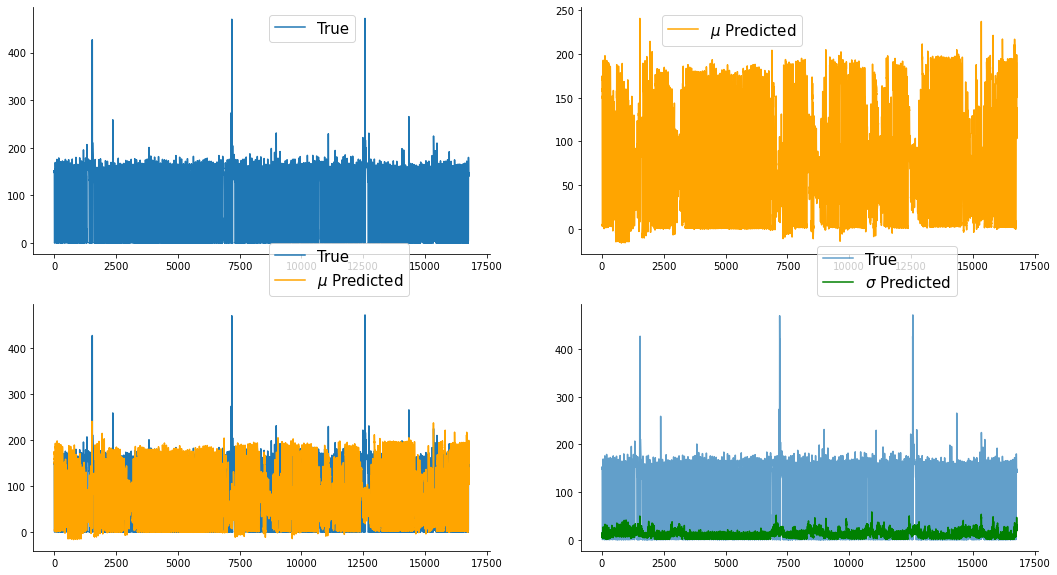

In [92]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

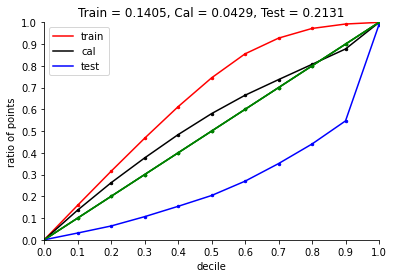

In [93]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(bs_train_mean.squeeze(), bs_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(bs_cal_mean.squeeze(), bs_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(bs_test_mean.squeeze(), bs_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Save Results

In [94]:
training_predictions_df.to_csv("notebooks/fridge/s2p/mlp/training_predictions.csv",index=False)
calibration_predictions_df.to_csv("notebooks/fridge/s2p/mlp/calibration_predictions.csv",index=False)
testing_predictions_df.to_csv("notebooks/fridge/s2p/mlp/testing_predictions.csv",index=False)

In [95]:
with open('notebooks/fridge/s2p/mlp/time.txt', 'w') as file:
    file.writelines([f"MLP training :{mlp_training_time} ",f" MLP Testing : {mlp_testing_time}\n"
               f"MC Testing : {mc_testing_time}\n", 
               f"DE Training Time : {de_training_time} ",f" DE Testing Time: {de_testing_time}\n", 
               f"BS Training Time : {bs_training_time} ",f" BS Testing Time: {bs_testing_time}"])